In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Desktop/BDAI2/Satellite_Super_Resulotion0")

import torch 
import torch.nn as nn
import torch.optim as optim

from importlib import reload    
import src.utils.config
reload(src.utils.config)
from src.utils.config import CONFIG

from src.utils.data_loader import create_loaders
from src.utils.models_architecture import EDSR       
from src.utils.train_model_sr import train_model_sr

best_model_path = CONFIG["model"]["best_EDSR_path"]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = CONFIG["training"]["epochs"]
step_size       = CONFIG["training"]["scheduler_step_size"]
gamma           = CONFIG["training"]["scheduler_gamma"]

best_model_path = CONFIG["model"]["best_EDSR_path"]
last_model_path = CONFIG["model"]["last_EDSR_path"]

history_path = CONFIG["history"]["EDSR_history_path"]

# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)

model = EDSR().to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.5)

SyntaxError: unterminated string literal (detected at line 29) (__init__.py, line 29)

Loading LAST checkpoint: src/models/checkpoints/EDSR/last_EDSR.pth
 Resume from epoch 150 | Best PSNR = 28.28
 Loading training history...


/home/jadli/Desktop/BDAI2/Satellite_Super_Resulotion0/src/utils/train_model_sr.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, 

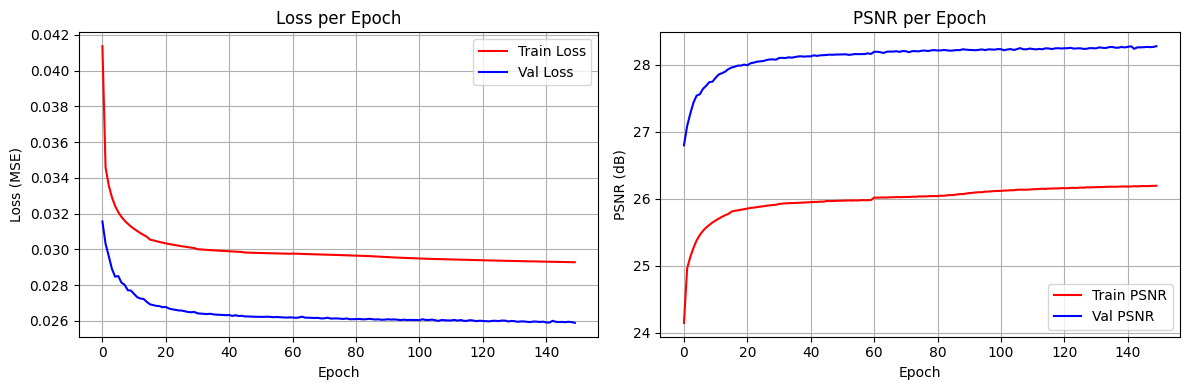

0

In [ ]:
train_model_sr(
    model=model,
    model_name="EDSR",
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    scale_factor=4,
    model_requires_upscale=False,
    best_model_path=best_model_path,
    last_model_path=last_model_path,
    history_path=history_path,
    mode="resume",        
    use_amp=True,
    scaler=None
)